# TP 5 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [11]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [12]:
from functions import *

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Restauracion de Imagenes - Trabajo de investigacion

In [14]:
lena = Image.open('img/lena_gray.tif')

## 1 - Inverse Filtering
Dado que se conoce la PSF (transformada de Fourier del proceso de degradacion h(x,y)) podemos aplicar el filtro inverso:
\begin{equation*}
    R(\omega_x,\omega_y) = \dfrac{1}{H(\omega_x,\omega_y)}
\end{equation*}

### a - Blur
Obtenemos el efecto de borroso aplicando un filtro pasabajos gaussiano y luego aplicamos filtro inverso

MSE: 5.568311472857696e-15


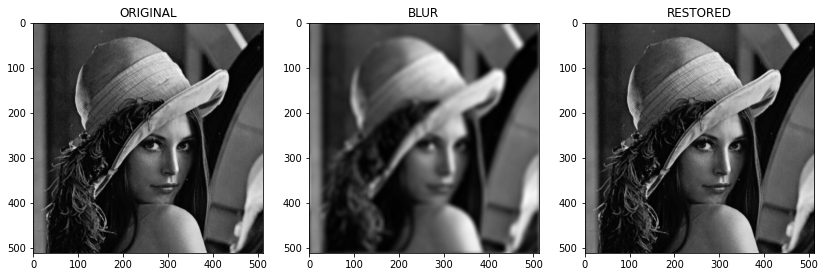

In [15]:
kernel = gaussian_kernel(size=15,sigma=5)
kernel = resize_kernel(lena.size,kernel)

img_blurd = apply_filter(lena,kernel)

restored = apply_inverse_filter(img_blurd,kernel)

images = {'ORIGINAL':lena,
          'BLUR':img_blurd,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

In [16]:
# order = 512//24
# kernel = np.ones((order,order),dtype=float)/(order*order) #Lowpass unit kernel
# kernel = resize_kernel(lena.size,kernel)

# img_blurd = apply_filter(lena,kernel)

# restored = apply_inverse_filter(img_blurd,kernel)

# images = {'ORIGINAL':lena,
#           'BLUR':img_blurd,
#           'RESTORED':restored
#         }

# print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
# compare(images)

### b - Blur + Noise

MSE: 55363012588535.71


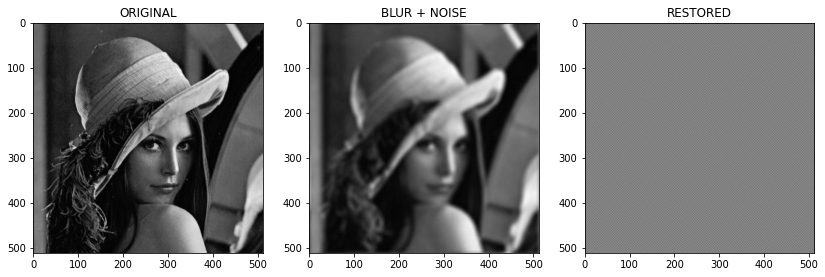

In [17]:
snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

restored = apply_inverse_filter(img_blurd_noisy,kernel)
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

## 2 - Wiener
Este filtro intenta resolver el problema de la amplificación del ruido buscando una solución de compromiso entre la calidad de la restauración y la amplificación del ruido. Suponiendo que la señal **s** y el ruido **n** son procesos aleatorios con media cero, si deseamos estimar la señal usando un estimador lineal:

\begin{equation*}
\hat{s}(x,y) = (s(x,y) + n(x,y))*h(x,y)
\end{equation*}

Entonces la ecuación del filtro de Wiener es:

\begin{equation*}
W(w_x,w_y) = \dfrac{H^*(w_x,w_y)S_{xx}(w_x,w_y)}{|H(w_x,w_y)|^2S_{xx}(w_x,w_y) + S_{nn}(w_x,w_y)}
\end{equation*}

Siendo $S_{xx}$ y $S_{nn}$ las densidades espectrales del ruido y H la respuesta en frecuencia del filtro degradador.

In [18]:
restored_wiener = apply_wiener_filter(lena, img_blurd_noisy, noise, kernel)

MSE: 79.14071458660722


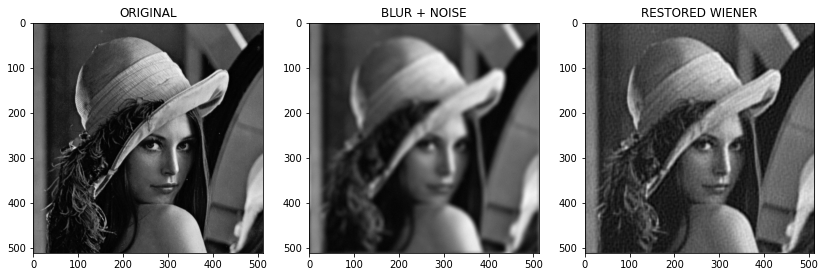

In [19]:
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED WIENER':restored_wiener
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED WIENER']).var())
compare(images)

## 3 - Blind deconvolution

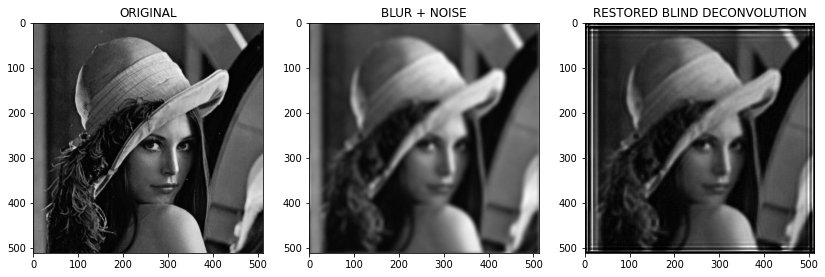

In [33]:
snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

n=10
kernel = np.full((n,n),1/n)
result = richardson_lucy(img_blurd_noisy.astype(np.float64)/255.0, kernel, num_iter=30)

images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED BLIND DECONVOLUTION':result}
compare(images)